In [158]:
!pip install 'matplotlib==2.0'
# !pip install networkx
!apt-get update
!apt-get install -y graphviz libgraphviz-dev pkg-config
!pip install pygraphviz --install-option="--include-path=/usr/include/graphviz" --install-option="--library-path=/usr/lib/graphviz/"
!pip install graphviz

Ign:1 http://deb.debian.org/debian stretch InRelease
Hit:2 http://security.debian.org/debian-security stretch/updates InRelease
Hit:3 http://deb.debian.org/debian stretch-updates InRelease
Hit:4 http://deb.debian.org/debian stretch Release 
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-17).
libgraphviz-dev is already the newest version (2.38.0-17).
pkg-config is already the newest version (0.29-4+b1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
/usr/local/lib/python3.5/site-packages/pip/_internal/commands/install.py:211: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [165]:
df = pd.read_csv('data/test.csv')

In [166]:
df.head()

,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0,35,self-employed,married,basic.9y,no,yes,no,telephone,6,2,2,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,1,27,admin.,married,professional.course,no,no,no,cellular,5,4,1,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1
2,2,28,blue-collar,single,basic.6y,no,no,no,telephone,5,3,2,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0
3,3,47,services,married,high.school,no,no,no,cellular,5,1,1,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1
4,4,53,unemployed,married,basic.4y,unknown,no,no,telephone,5,5,1,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0


In [167]:
data = df[['month', 'campaign', 'previous', 'marital', 'job']]

In [168]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
# data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
# data['A'] += data['B'] + data['C']
# data['H'] = data['G'] - data['A']

hc = HillClimbSearch(mydata, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())

[('job', 'marital'), ('month', 'previous'), ('month', 'job')]


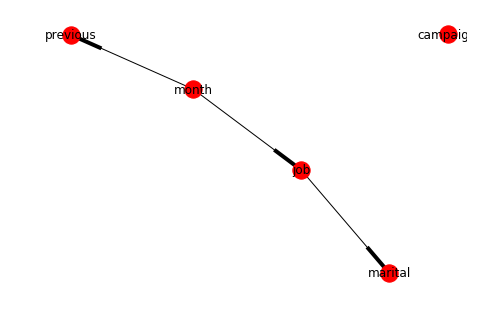

In [169]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show()

### Constraint-based Structure Learning

#### (Conditional) Independence Tests

In [8]:
from pgmpy.estimators import ConstraintBasedEstimator

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

est = ConstraintBasedEstimator(data)

print(est.test_conditional_independence('B', 'H'))          # dependent
print(est.test_conditional_independence('B', 'E'))          # independent
print(est.test_conditional_independence('B', 'H', ['A']))   # independent
print(est.test_conditional_independence('A', 'G'))          # independent
print(est.test_conditional_independence('A', 'G',  ['H']))  # dependent

(699.97405783564182, 7.3444216289609015e-131, True)
(8.7277046327265051, 0.64701015287657437, True)
(14.957436611462951, 0.99998762836762323, True)
(13.931300545151938, 0.83396199804620841, True)
(4652.0, 0.0, True)


In [9]:
def is_independent(X, Y, Zs=[], significance_level=0.05):
    return est.test_conditional_independence(X, Y, Zs)[1] >= significance_level

print(is_independent('B', 'H'))
print(is_independent('B', 'E'))
print(is_independent('B', 'H', ['A']))
print(is_independent('A', 'G'))
print(is_independent('A', 'G', ['H']))

False
True
True
True
False


#### DAG (pattern) construction

In [10]:
skel, seperating_sets = est.estimate_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

Undirected edges:  [('H', 'G'), ('H', 'A'), ('F', 'E'), ('C', 'A'), ('B', 'A')]
PDAG edges:        [('F', 'E'), ('C', 'A'), ('B', 'A'), ('A', 'H'), ('E', 'F'), ('G', 'H')]
DAG edges:         [('C', 'A'), ('B', 'A'), ('A', 'H'), ('E', 'F'), ('G', 'H')]


In [11]:
print(est.estimate(significance_level=0.01).edges())


[('C', 'A'), ('B', 'A'), ('A', 'H'), ('E', 'F'), ('G', 'H')]


In [12]:
from pgmpy.independencies import Independencies

ind = Independencies(['B', 'C'],
                     ['A', ['B', 'C'], 'D'])
ind = ind.closure()  # required (!) for faithfulness

model = ConstraintBasedEstimator.estimate_from_independencies("ABCD", ind)

print(model.edges())

[('C', 'D'), ('B', 'D'), ('A', 'D')]
